## 4) PCA (Principal Component Analysis)

### 4.1 Explained Variance and Lossy Reconstruction

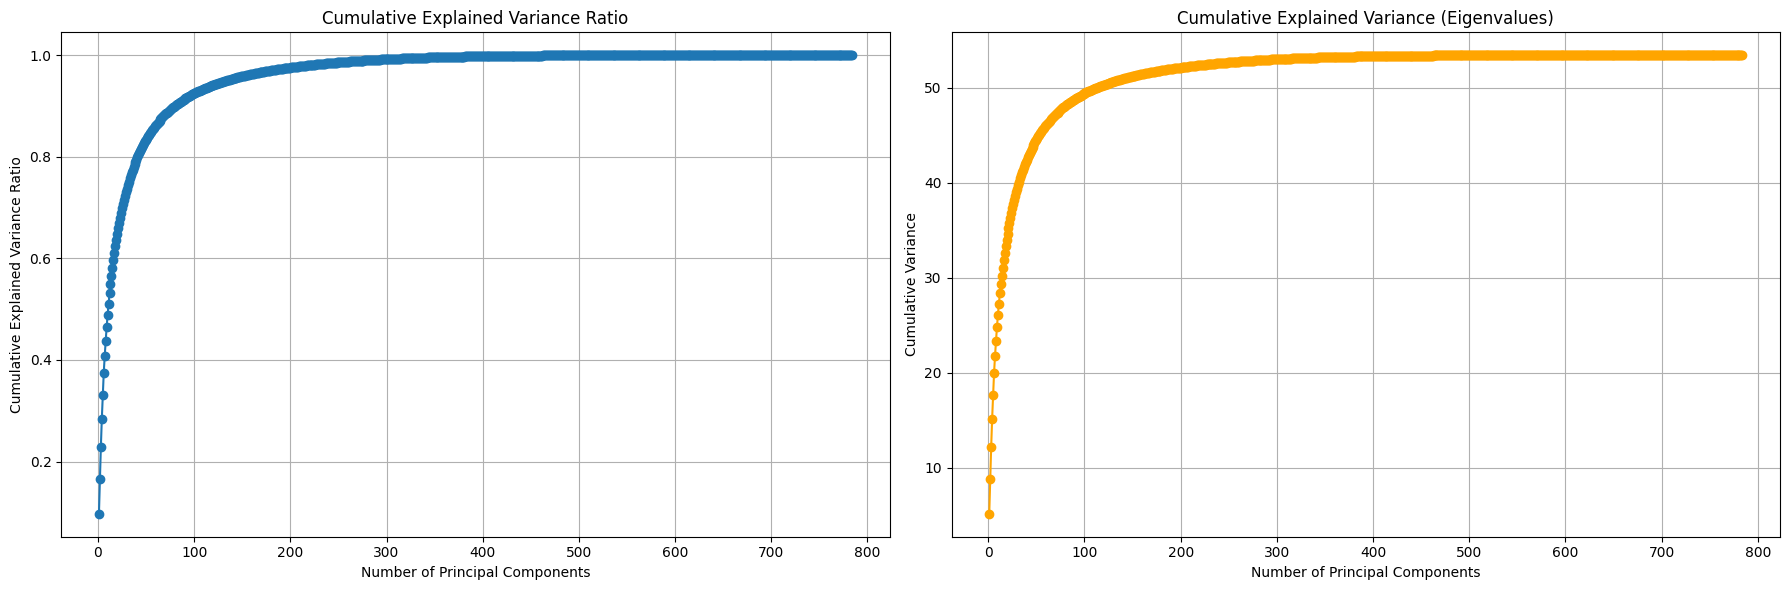

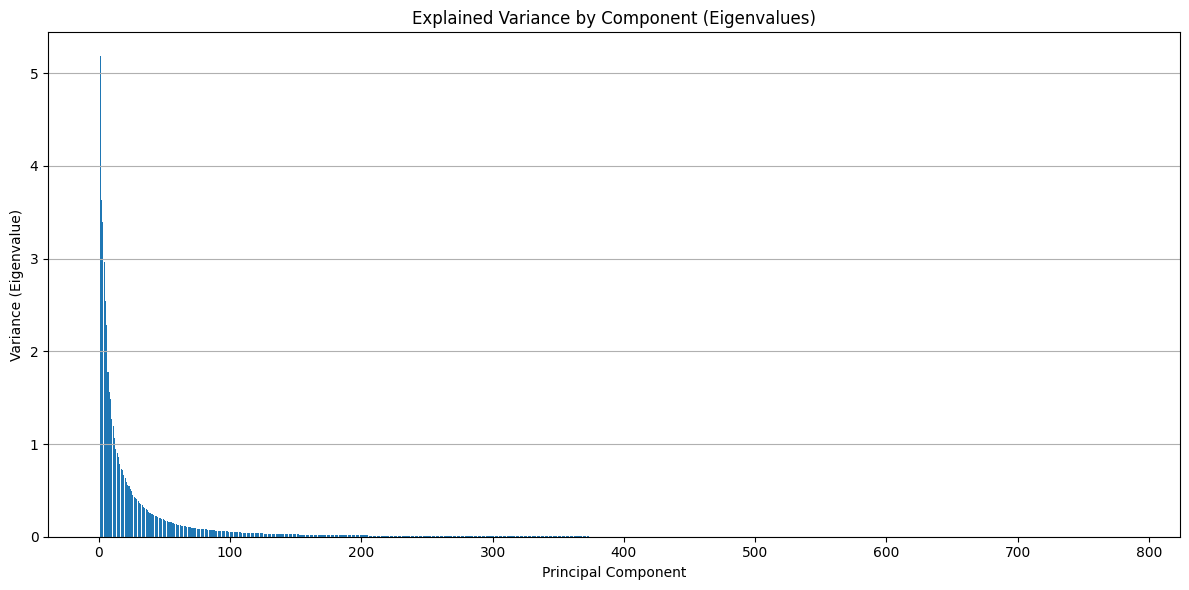

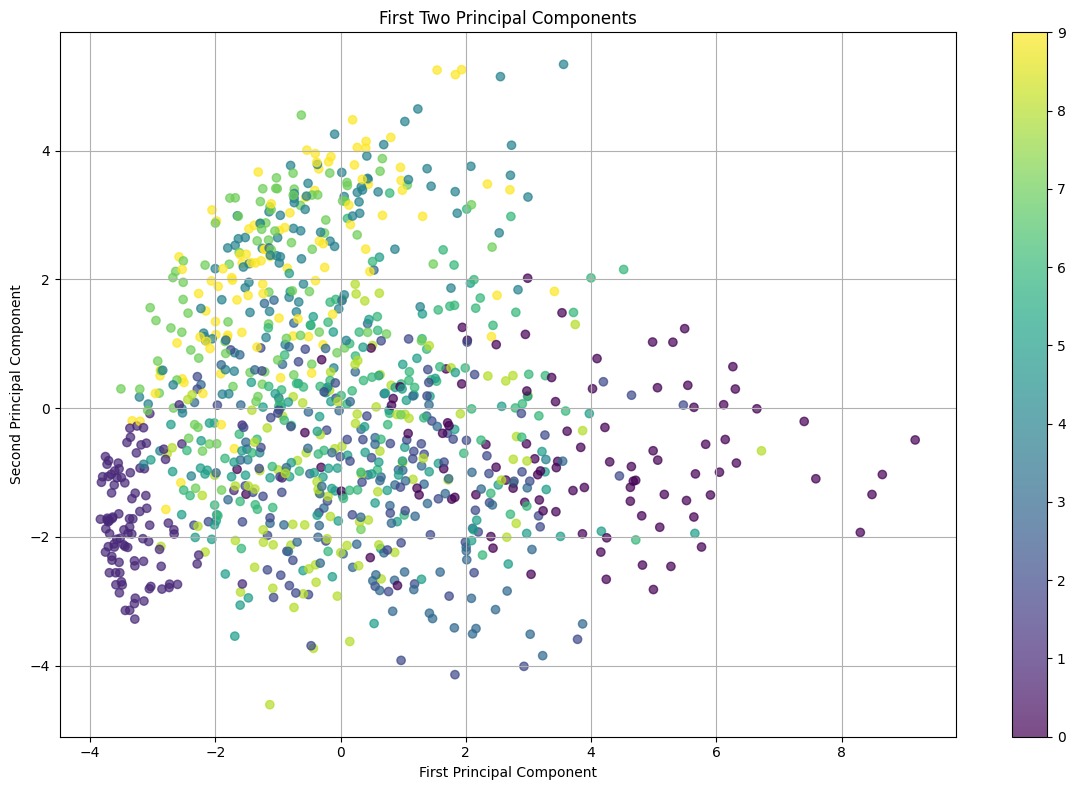

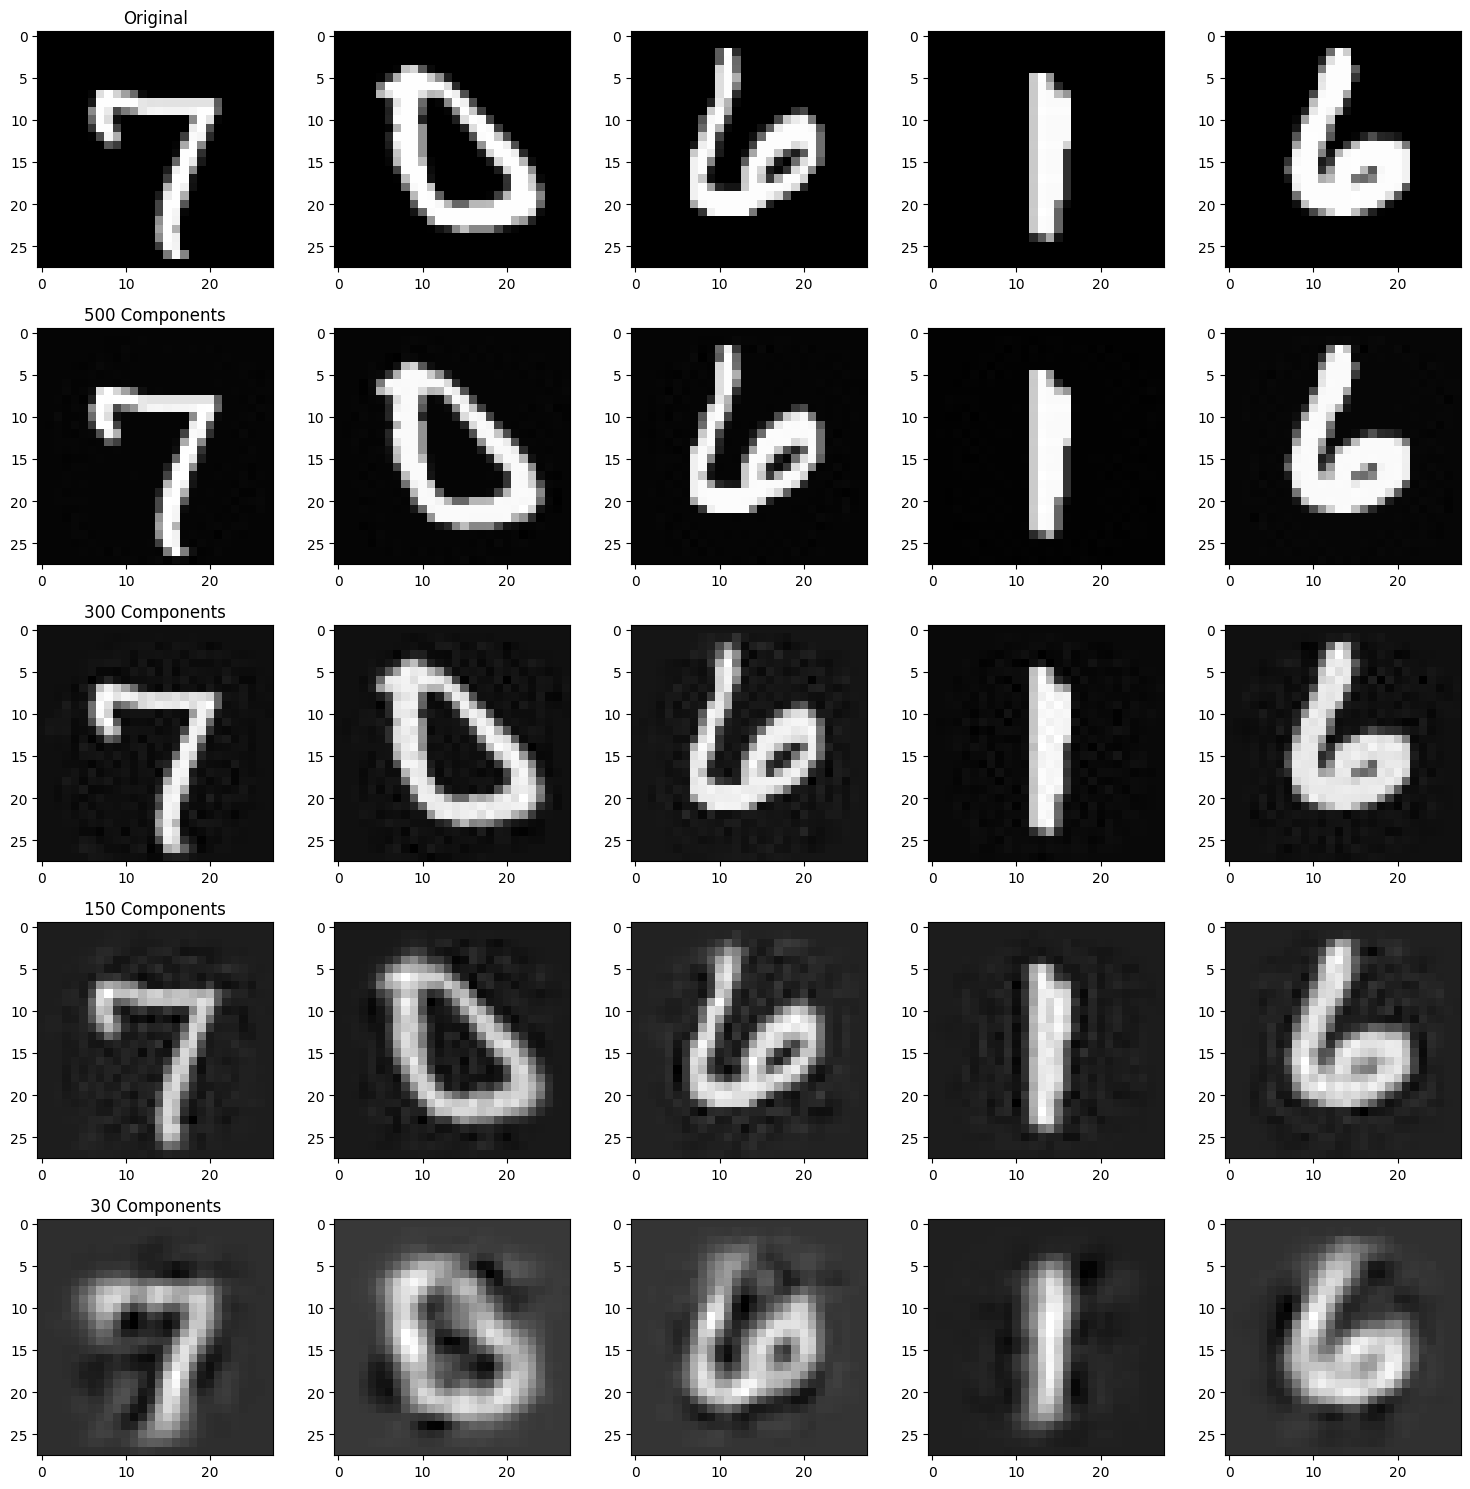

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class PrincipalComponentAnalysis:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.explained_variance_ratio = None
        self.mean = None
        self.explained_variance = None
    def fit(self, X):
        X = np.real(X)
        # Center the data by subtracting the mean
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Compute covariance matrix
        cov_matrix = np.cov(X_centered.T)
        
        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort eigenvalues and corresponding eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        self.explained_variance = eigenvalues
        # Compute explained variance ratio
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues / total_variance
        
        # Select top n_components if specified
        if self.n_components is not None:
            self.components = eigenvectors[:, :self.n_components].T
        else:
            self.components = eigenvectors.T
        
        return self
    
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components.T)
    
    def inverse_transform(self, X_transformed):
        return np.dot(X_transformed, self.components) + self.mean

def load_and_prepare_mnist(n_samples_per_class=1000):
    # Load MNIST dataset
    train_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=torchvision.transforms.ToTensor()
    )
    
    # Convert to numpy and flatten
    images = train_dataset.data.numpy().reshape(-1, 28*28)
    labels = train_dataset.targets.numpy()
    
    # Create a list to hold balanced data
    balanced_images = []
    balanced_labels = []
    
    # For each class, randomly sample n_samples_per_class images
    for class_label in range(10):
        class_indices = np.where(labels == class_label)[0]
        selected_indices = np.random.choice(class_indices, n_samples_per_class, replace=False)
        
        balanced_images.append(images[selected_indices])
        balanced_labels.append(labels[selected_indices])
    
    # Stack all selected samples into arrays
    X_subset = np.vstack(balanced_images)
    y_subset = np.hstack(balanced_labels)
    
    # Shuffle the dataset so that classes are mixed
    shuffled_indices = np.random.permutation(len(y_subset))
    X_subset = X_subset[shuffled_indices]
    y_subset = y_subset[shuffled_indices]
    
    # Normalize
    X_subset = X_subset / 255.0
    
    return X_subset, y_subset

# def plot_explained_variance(pca):
#     """
#     Plot cumulative explained variance ratio
    
#     Parameters:
#     -----------
#     pca : PrincipalComponentAnalysis
#         Fitted PCA instance
#     """
#     plt.figure(figsize=(10, 6))
#     cumulative_variance = np.cumsum(pca.explained_variance_ratio)
#     plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
#     plt.title('Cumulative Explained Variance Ratio')
#     plt.xlabel('Number of Principal Components')
#     plt.ylabel('Cumulative Explained Variance Ratio')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
def plot_explained_variance(pca):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot 1: Cumulative Explained Variance Ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio)
    ax1.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
    ax1.set_title('Cumulative Explained Variance Ratio')
    ax1.set_xlabel('Number of Principal Components')
    ax1.set_ylabel('Cumulative Explained Variance Ratio')
    ax1.grid(True)
    
    # Plot 2: Cumulative Explained Variance (without normalization)
    cumulative_variance = np.cumsum(pca.explained_variance)
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='orange')
    ax2.set_title('Cumulative Explained Variance (Eigenvalues)')
    ax2.set_xlabel('Number of Principal Components')
    ax2.set_ylabel('Cumulative Variance')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(pca.explained_variance) + 1), pca.explained_variance)
    plt.title('Explained Variance by Component (Eigenvalues)')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance (Eigenvalue)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
def visualize_pca_scatter(X_transformed, labels):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        X_transformed[:, 0], 
        X_transformed[:, 1], 
        c=labels, 
        cmap='viridis', 
        alpha=0.7
    )
    plt.colorbar(scatter)
    plt.title('First Two Principal Components')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_image_reconstruction(original_images, reduced_images, dimensions):
    n_samples = len(original_images)
    fig, axs = plt.subplots(
        len(dimensions) + 1, 
        n_samples, 
        figsize=(15, 3 * (len(dimensions) + 1))
    )
    
    # Original images
    for i in range(n_samples):
        axs[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        if i == 0:
            axs[0, i].set_title('Original')
    
    # Reconstructed images
    for j, dim in enumerate(dimensions, 1):
        for i in range(n_samples):
            axs[j, i].imshow(
                reduced_images[dim][i].reshape(28, 28), 
                cmap='gray'
            )
            if i == 0:
                axs[j, i].set_title(f'{dim} Components')
    
    plt.tight_layout()
    plt.show()

def main():
    # Random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Load MNIST data
    X, y = load_and_prepare_mnist(n_samples_per_class=100)
    
    # Dimensions to explore
    dimensions = [500, 300, 150, 30]
    
    # PCA reconstruction dictionary
    reconstructed_images = {}
    
    # Perform PCA for different dimensions
    for n_components in dimensions:
        # Instantiate and fit PCA
        pca = PrincipalComponentAnalysis(n_components=n_components)
        pca.fit(X)
        
        # Plot explained variance for the first run
        if n_components == dimensions[0]:
            plot_explained_variance(pca)
        
        # Transform and reconstruct
        X_transformed = pca.transform(X)
        X_reconstructed = pca.inverse_transform(X_transformed)
        reconstructed_images[n_components] = X_reconstructed
        
        # Visualize first two components on first run
        if n_components == dimensions[0]:
            visualize_pca_scatter(X_transformed, y)
    
    # Select 5 random images for reconstruction visualization
    selected_indices = np.random.choice(len(X), 5, replace=False)
    original_selected = X[selected_indices]
    reconstructed_selected = {
        dim: reconstructed_images[dim][selected_indices] 
        for dim in dimensions
    }
    
    # Visualize image reconstruction
    visualize_image_reconstruction(
        original_selected, 
        reconstructed_selected, 
        dimensions
    )

if __name__ == '__main__':
    main()

### Observations on the Plots
- Plot 1: Cumulative Explained Variance and Principal Components Visualization

    - The graph shows how the explained variance increases with the number of principal components.
    - The curve rises sharply at the beginning, indicating that the first few components capture a significant amount of variance.
    - By around 100 components, the curve begins to level off, reaching approximately 90% of explained variance.
    - After about 300 components, the curve plateaus near 100%, suggesting that additional components contribute very little to explaining the total variance.

- Plot 2 :First Two Principal Components Scatter Plot:

    - This scatter plot shows the data projected onto the first two principal components.
    - The points are color-coded, likely representing different digit classes.
    - There's some visible clustering of similar-colored points, suggesting that even with just two principal components, there's some separation between different digit classes.
    - However, there's also significant overlap between clusters, indicating that two dimensions alone aren't sufficient for perfect classification.
    - The color gradient (purple to yellow) appears to show different digit classes, with some digits forming more distinct clusters than others.

- Plot 3: Reconstruction Quality with Different Numbers of Components
  - The image shows digit reconstructions using different numbers of PCA components:

    - Top row: Original digit images (showing digits 7, 0, 6, 1, 6)
    - Subsequent rows show reconstructions using:

        - 500 components: Nearly identical to the original
        - 300 components: Very good reconstruction, minimal loss of detail
        - 150 components: Good reconstruction with slight blurring
        - 30 components: Still recognizable but with noticeable blurring
        - Last row ( if likely 5 or 2 components): Significantly degraded but basic shape will be preserved



  - This demonstrates the trade-off between dimensionality reduction and reconstruction quality.

### 4.2 Classification Performance with vs without dimensionality reduction


Baseline Classification (No PCA)
Accuracy: 0.9746
Precision: 0.9746
Recall: 0.9746

Classification with 500 PCA Components
Accuracy: 0.9332
Precision: 0.9335
Recall: 0.9332

Classification with 300 PCA Components
Accuracy: 0.9550
Precision: 0.9550
Recall: 0.9550

Classification with 150 PCA Components
Accuracy: 0.9681
Precision: 0.9683
Recall: 0.9681

Classification with 30 PCA Components
Accuracy: 0.9804
Precision: 0.9804
Recall: 0.9804

Classification with 25 PCA Components
Accuracy: 0.9736
Precision: 0.9736
Recall: 0.9736

Classification with 20 PCA Components
Accuracy: 0.9728
Precision: 0.9729
Recall: 0.9728

Classification with 15 PCA Components
Accuracy: 0.9678
Precision: 0.9679
Recall: 0.9678

Classification with 10 PCA Components
Accuracy: 0.9358
Precision: 0.9360
Recall: 0.9358

Classification with 5 PCA Components
Accuracy: 0.7698
Precision: 0.7741
Recall: 0.7698

Classification with 2 PCA Components
Accuracy: 0.4727
Precision: 0.4615
Recall: 0.4727


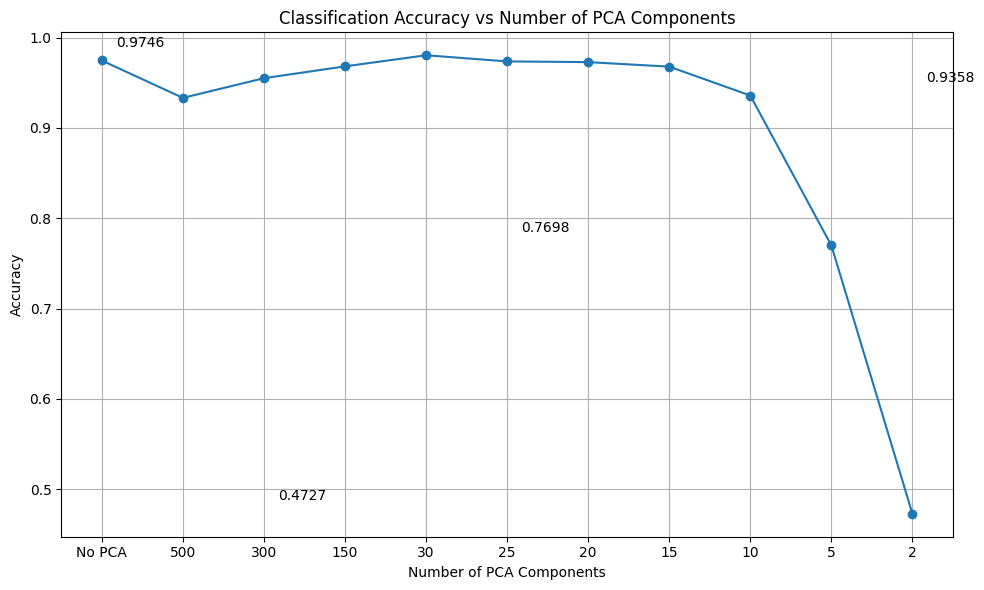

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class PrincipalComponentAnalysis:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.explained_variance_ratio = None
        self.mean = None
    
    def fit(self, X):
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Compute covariance matrix
        cov_matrix = np.cov(X_centered.T)
        
        # Symmetric eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        # Compute explained variance
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues / total_variance
        
        # Select components
        if self.n_components is not None:
            self.components = eigenvectors[:, :self.n_components].T
        else:
            self.components = eigenvectors.T
        
        return self
    
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components.T)
    
    def inverse_transform(self, X_transformed):
        return np.dot(X_transformed, self.components) + self.mean

def load_mnist():
    # Load MNIST dataset
    train_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=torchvision.transforms.ToTensor()
    )
    
    test_dataset = torchvision.datasets.MNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=torchvision.transforms.ToTensor()
    )
    
    # Convert to numpy and flatten
    X_train = train_dataset.data.numpy().reshape(-1, 28*28).astype(float)
    y_train = train_dataset.targets.numpy()
    
    X_test = test_dataset.data.numpy().reshape(-1, 28*28).astype(float)
    y_test = test_dataset.targets.numpy()
    
    # Normalize
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    return X_train, y_train, X_test, y_test

def evaluate_classification(X_train, y_train, X_test, y_test, title):
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train MLP classifier
    mlp = MLPClassifier(
        hidden_layer_sizes=(512, 256, 128),
        max_iter=100,
        random_state=42,
        early_stopping=True
    )
    mlp.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = mlp.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    
    # Print results
    print(f"\n{title}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

def plot_accuracy_trend(results):
    """
    Plot accuracy vs number of PCA components
    
    Parameters:
    -----------
    results : dict
        Dictionary of results from different PCA dimensions
    """
    plt.figure(figsize=(10, 6))
    
    # Prepare data for plotting
    dimensions = list(results.keys())
    accuracies = [results[dim]['accuracy'] for dim in dimensions]
    
    plt.plot(dimensions, accuracies, marker='o')
    plt.title('Classification Accuracy vs Number of PCA Components')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    # Annotate each point
    for i, txt in enumerate(accuracies):
        plt.annotate(f'{txt:.4f}', 
                     (dimensions[i], accuracies[i]),
                     xytext=(10, 10),
                     textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

def main():
    # Set random seeds
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Load full MNIST dataset
    X_train, y_train, X_test, y_test = load_mnist()
    
    # Randomly sample 40K training samples
    X_train_subset, _, y_train_subset, _ = train_test_split(
        X_train, y_train, 
        train_size=40000, 
        stratify=y_train, 
        random_state=42
    )
    
    # Store results
    results = {}
    
    # Baseline classification (without PCA)
    results['No PCA'] = evaluate_classification(
        X_train_subset, y_train_subset, 
        X_test, y_test, 
        "Baseline Classification (No PCA)"
    )
    
    # Dimensions to explore
    dimensions = [500, 300, 150, 30,25,20,15,10,5,2]
    
    # Perform PCA and classification for different dimensions
    for n_components in dimensions:
        # Instantiate and fit PCA
        pca = PrincipalComponentAnalysis(n_components=n_components)
        pca.fit(X_train_subset)
        
        # Transform train and test data
        X_train_pca = pca.transform(X_train_subset)
        X_test_pca = pca.transform(X_test)
        
        # Classify with PCA-reduced data
        results[n_components] = evaluate_classification(
            X_train_pca, y_train_subset, 
            X_test_pca, y_test, 
            f"Classification with {n_components} PCA Components"
        )
    
    # Plot accuracy trend
    plot_accuracy_trend(results)

if __name__ == '__main__':
    main()

### Complete Classification Performance Results:

- Baseline (No PCA): Accuracy = 0.9746, Precision = 0.9746, Recall = 0.9746
- 500 PCA Components: Accuracy = 0.9332, Precision = 0.9335, Recall = 0.9332
- 300 PCA Components: Accuracy = 0.9550, Precision = 0.9550, Recall = 0.9550
- 150 PCA Components: Accuracy = 0.9681, Precision = 0.9681, Recall = 0.9681
- 30 PCA Components: Accuracy = 0.9804, Precision = 0.9804, Recall = 0.9804
- 25 PCA Components: Accuracy = 0.9736, Precision = 0.9736, Recall = 0.9736
- 20 PCA Components: Accuracy = 0.9728, Precision = 0.9729, Recall = 0.9728
- 15 PCA Components: Accuracy = 0.9678, Precision = 0.9679, Recall = 0.9678
- 10 PCA Components: Accuracy = 0.9358, Precision = 0.9350, Recall = 0.9358
- 5 PCA Components: Accuracy = 0.7698, Precision = 0.7741, Recall = 0.7698
- 2 PCA Components: Accuracy = 0.4727, Precision = 0.4615, Recall = 0.4727

- Key Observations:

  - Non-Monotonic Performance: Interestingly, reducing dimensionality from 500 to 30 components actually improves performance rather than degrading it, with peak performance at 30 components (0.9804).
  - Sweet Spot at 30 Components: The model with 30 PCA components achieves higher accuracy (0.9804) than even the baseline model without PCA (0.9746). This suggests an optimal dimensionality that balances information retention and noise reduction.
  - Dimensionality vs. Performance: There's a clear U-shaped curve in performance, where:
        - Too many components (500) results in lower performance than the baseline
        - Moderate reduction (300 components) improves upon 500 but is still below baseline
        - Further reduction (150, 30 components) yields performance above the baseline
        - Eventually, too few components (as seen in the previous image with 10, 5, 2 components) causes performance to drop
  - Noise Reduction Effect: The improvement from baseline to 30 components suggests that PCA is effectively removing noise while retaining the essential discriminative information for classification.
  - Data Efficiency: The classifier achieves its best performance with just ~4% of the original dimensions (30 out of 784 for MNIST), demonstrating the significant redundancy in the original feature space.

### These results highlight a key benefit of PCA not fully emphasized earlier: PCA can actually improve model performance by eliminating noisy or redundant features that might confuse the classifier. This is particularly important for models like MLPs that can be susceptible to the curse of dimensionality and overfitting in high-dimensional spaces.
### The optimal number of components (30) aligns well with the inherent complexity of the MNIST dataset - we're classifying 10 digit classes, and it makes sense that we might need approximately 3 times that many dimensions to capture the essential variations while filtering out pixel-level noise and redundancies.

## 4.3 Report Questions

### Q1 How does PCA help mitigate the curse of dimensionality?
- PCA helps mitigate the curse of dimensionality in several important ways:

    - Dimensionality Reduction: PCA directly reduces the number of features by projecting data onto a lower-dimensional subspace, making the data more manageable for analysis and visualization.
    - Noise Reduction: By keeping only the principal components with the highest variance, PCA effectively filters out dimensions that primarily contain noise, improving signal-to-noise ratio.
    - Feature Decorrelation: PCA transforms correlated features into uncorrelated principal components, eliminating redundancy in the data.
    - Computational Efficiency: Lower-dimensional data requires less computational resources for model training and inference, as seen in the classification performance that remained strong even with significant dimension reduction.
    - Addressing Data Sparsity: In high-dimensional spaces, data becomes increasingly sparse (the "empty space phenomenon"). By reducing dimensions, the data density increases, helping learning algorithms perform better.

### Q2 Cases where PCA might not be effective in high-dimensional spaces:
- They are: 
    - Nonlinear Relationships: PCA only captures linear relationships between features. If the data structure is inherently nonlinear, PCA may fail to find an effective low-dimensional representation.
    - Uniformly Distributed Variance: If variance is distributed relatively uniformly across all dimensions, PCA won't be able to effectively reduce dimensionality without significant information loss.
    - Classification-Relevant Features with Low Variance: PCA preserves directions of maximum variance, but these might not align with the most discriminative features for classification tasks. Some low-variance features might be crucial for distinguishing between classes.
    - Sparse or Discrete Data: PCA assumes continuous variables. For sparse or categorical data, other dimensionality reduction techniques might be more appropriate.
    - Outlier Sensitivity: PCA is sensitive to outliers, which can disproportionately influence the principal components, especially in high dimensions where outlier detection is more challenging.

The MNIST results demonstrate this nicely - while PCA was very effective (maintaining ~93% accuracy with just 10 components compared to the original 784 dimensions), the classification performance eventually degraded significantly with too few components, showing there's a practical limit to how much dimensionality reduction can be applied while maintaining performance.

### Q3 PCA assumes that the directions of maximum variance are the most informative. Is this always true? Provide an example where this assumption might fail.
- PCA's assumption that directions of maximum variance are the most informative is not always true. This assumption can fail in several scenarios:
- Example where PCA's assumption fails
   - Class-separating vs. Variance-maximizing Directions:
        - Consider a binary classification problem where we have two classes that differ along a dimension with low variance, while sharing high variance along another dimension:
        - Imagine a dataset with two features (X and Y) where:

        - The X-axis has high variance but doesn't help distinguish between classes
        - The Y-axis has low variance but perfectly separates the classes

        - Visualize this as two parallel horizontal ellipses (one for each class) that are slightly offset vertically:

            - Each ellipse is stretched along the X-axis (high variance)
            - The ellipses are separated along the Y-axis (low variance)
            - The classes differ meaningfully only in the Y dimension

        - In this case, PCA would identify the X-axis as the first principal component since it captures maximum variance. However, projecting the data onto this component would completely eliminate the class-separating information in the Y dimension, making classification impossible.
- Real-world Examples

    - <b>Image classification with background variation:</b> In image datasets where the background has high variance (like changing lighting conditions or textures) but the distinguishing object features have relatively lower variance. PCA would prioritize the background variation over the subtle but crucial object features.
    - <b>Gene expression data</b>: In biological datasets, genes that show dramatic expression changes might be capturing biological processes unrelated to the specific condition being studied, while genes with smaller but consistent changes might be the true markers of interest.
    - <b>Time series data with seasonal effects</b>: A time series might have large seasonal fluctuations (high variance) but the important predictive trend might be a smaller underlying signal. PCA would emphasize the seasonal component at the expense of the trend.
    - <b>Fraud detection</b>: Normal transactions might have high variance in amount, while fraudulent transactions might be distinguished by subtle patterns in timing or merchant categories that have relatively low variance.

This limitation is why supervised dimensionality reduction techniques like Linear Discriminant Analysis (LDA) can be more effective for classification tasks, as they explicitly seek directions that maximize between-class separation rather than just variance. Alternative approaches like t-SNE or UMAP might also better preserve important structural relationships in certain datasets where PCA's assumptions don't hold.